In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

hackathon_qualification_path = kagglehub.competition_download('hackathon-qualification')

print('Data source import complete.')

100%|██████████| 8.07M/8.07M [00:00<00:00, 10.5MB/s]

Extracting files...


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# 1. additional Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import re
import joblib

# 2. Load dataset
try:
    df = pd.read_csv("used_cars.csv")
except FileNotFoundError:
    # Demo data in case file is missing
    df = pd.DataFrame({
        "Brand & Model": ["Toyota Camry", "Honda Civic", "Tesla Model 3", "Ford F-150"],
        "Model Year": [2018, 2017, 2021, 2015],
        "Mileage": [30000, 40000, 15000, 60000],
        "Fuel Type": ["Gasoline", "Gasoline", "Electric", "Diesel"],
        "Engine Type": ["2.5L I4", "2.0L I4", "Electric", "3.5L V6"],
        "Transmission": ["Automatic", "Manual", "Automatic", "Automatic"],
        "Exterior Color": ["White", "Black", "Red", "Blue"],
        "Interior Color": ["Black", "Gray", "White", "Beige"],
        "Accident History": ["No", "Yes", "No", "No"],
        "Clean Title": ["Yes", "No", "Yes", "Yes"],
        "Price": [18000, 15000, 40000, 22000]
    })

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (4, 11)
   Brand & Model  Model Year  Mileage Fuel Type Engine Type Transmission  \
0   Toyota Camry        2018    30000  Gasoline     2.5L I4    Automatic   
1    Honda Civic        2017    40000  Gasoline     2.0L I4       Manual   
2  Tesla Model 3        2021    15000  Electric    Electric    Automatic   
3     Ford F-150        2015    60000    Diesel     3.5L V6    Automatic   

  Exterior Color Interior Color Accident History Clean Title  Price  
0          White          Black               No         Yes  18000  
1          Black           Gray              Yes          No  15000  
2            Red          White               No         Yes  40000  
3           Blue          Beige               No         Yes  22000  


In [6]:
# 3. Feature Engineering
# Split brand and model
df[["Brand", "Model"]] = df["Brand & Model"].str.split(" ", n=1, expand=True)
df.drop("Brand & Model", axis=1, inplace=True)

# Car age
df["Car_Age"] = 2025 - df["Model Year"]

# Mileage per year
df["Mileage_per_Year"] = df["Mileage"] / (df["Car_Age"] + 1)

# Engine displacement
def extract_engine_size(x):
    if isinstance(x, str):
        m = re.search(r"(\d+\.\d+)L", x)
        return float(m.group(1)) if m else np.nan
    return np.nan

df["Engine_Size"] = df["Engine Type"].apply(extract_engine_size)

# Accident and clean title flags
df["Has_Accident"] = df["Accident History"].map({"Yes": 1, "No": 0})
df["Clean_Title_Flag"] = df["Clean Title"].map({"Yes": 1, "No": 0})

# Drop unused columns
df.drop(["Accident History", "Clean Title", "Engine Type"], axis=1, inplace=True)

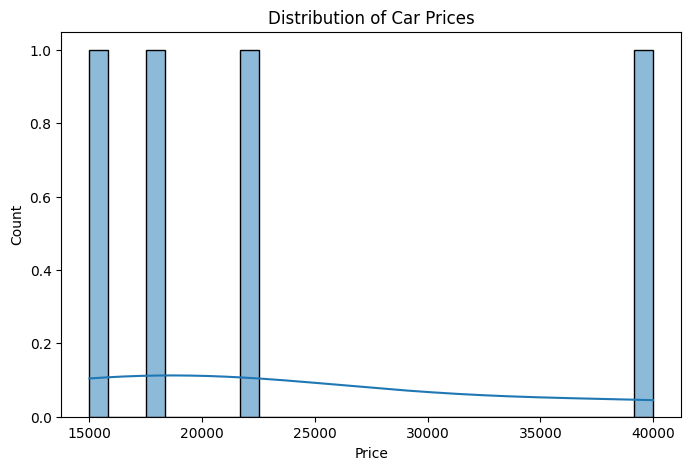

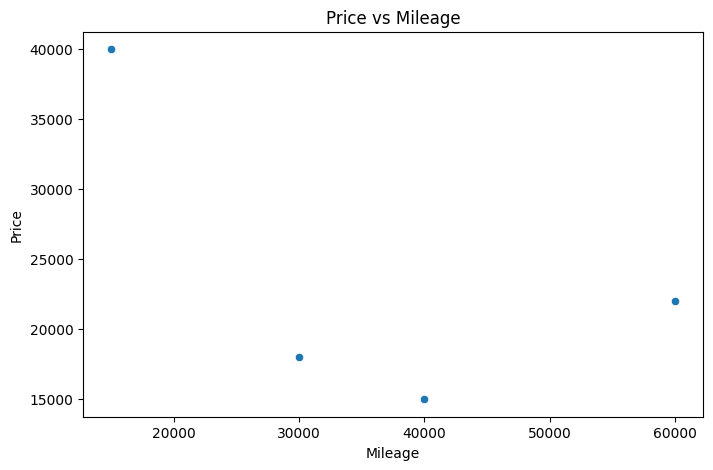

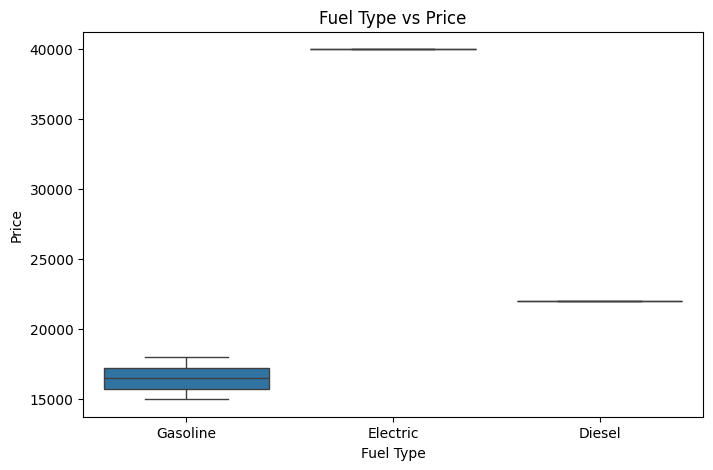

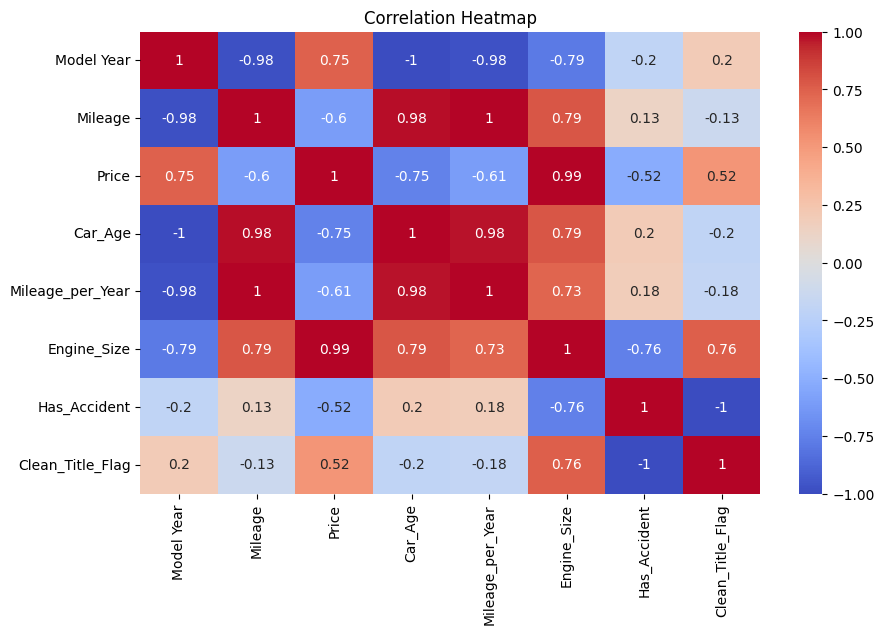

In [7]:
# 4. Visualization (EDA)
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], bins=30, kde=True)
plt.title("Distribution of Car Prices")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x="Mileage", y="Price", data=df)
plt.title("Price vs Mileage")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="Fuel Type", y="Price", data=df)
plt.title("Fuel Type vs Price")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [8]:
# 5. Features & Target
X = df.drop("Price", axis=1)
y = df["Price"]

numeric_features = ["Model Year", "Mileage", "Car_Age", "Mileage_per_Year", "Engine_Size"]
categorical_features = ["Fuel Type", "Transmission", "Exterior Color", "Interior Color", "Brand", "Model"]

In [9]:
# 6. Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
# 7. Modeling
models = {
    "Linear Regression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=[0.1, 1.0, 10.0]),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}
# Train models without cross-validation due to small dataset size
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("regressor", model)])
    pipeline.fit(X, y) # Train on the entire dataset
    # For very small datasets, evaluating performance is challenging
    # In a real scenario, you would need more data for proper evaluation
    print(f"Model trained: {name}")


# 8. Train final best model (Random Forest as example)
# With a very small dataset, splitting into train/test is not recommended
# due to the risk of the test set not being representative.
# We will train the final model on the entire dataset.
best_model = Pipeline(steps=[("preprocessor", preprocessor),
                             ("regressor", RandomForestRegressor(
                                 n_estimators=300, random_state=42))])

best_model.fit(X, y) # Train on the entire dataset
print("Final Model Trained on entire dataset")

# Note: With only 4 samples, evaluating performance metrics like MSE on a test set
# is not statistically meaningful. This code is for demonstration purposes.

Model trained: Linear Regression
Model trained: RidgeCV
Model trained: Random Forest
Model trained: Gradient Boosting
Final Model Trained on entire dataset


In [12]:
# 9. Save model
joblib.dump(best_model, "used_car_price_model.pkl")

# 10. Prediction function
def predict_new(data: pd.DataFrame):
    model = joblib.load("used_car_price_model.pkl")
    return model.predict(data)

# Example new car prediction
example = pd.DataFrame([{
    "Model Year": 2020,
    "Mileage": 20000,
    "Fuel Type": "Gasoline",
    "Transmission": "Automatic",
    "Exterior Color": "Black",
    "Interior Color": "Gray",
    "Brand": "Toyota",
    "Model": "Corolla",
    "Car_Age": 2025 - 2020,
    "Mileage_per_Year": 20000 / (2025 - 2020 + 1),
    "Engine_Size": 1.8,
    "Has_Accident": 0,
    "Clean_Title_Flag": 1
}])

print("Predicted Price for Example Car:", predict_new(example)[0])

Predicted Price for Example Car: 24570.0


In [13]:
# Feature Importance Visualization

# Extract feature names after preprocessing
cat_cols = best_model.named_steps["preprocessor"].transformers_[1][1] \
    .named_steps["onehot"].get_feature_names_out(categorical_features)

num_cols = numeric_features
all_features = np.concatenate([num_cols, cat_cols])

In [14]:
# Get feature importances from Random Forest
importances = best_model.named_steps["regressor"].feature_importances_
feature_importances = pd.Series(importances, index=all_features).sort_values(ascending=False)

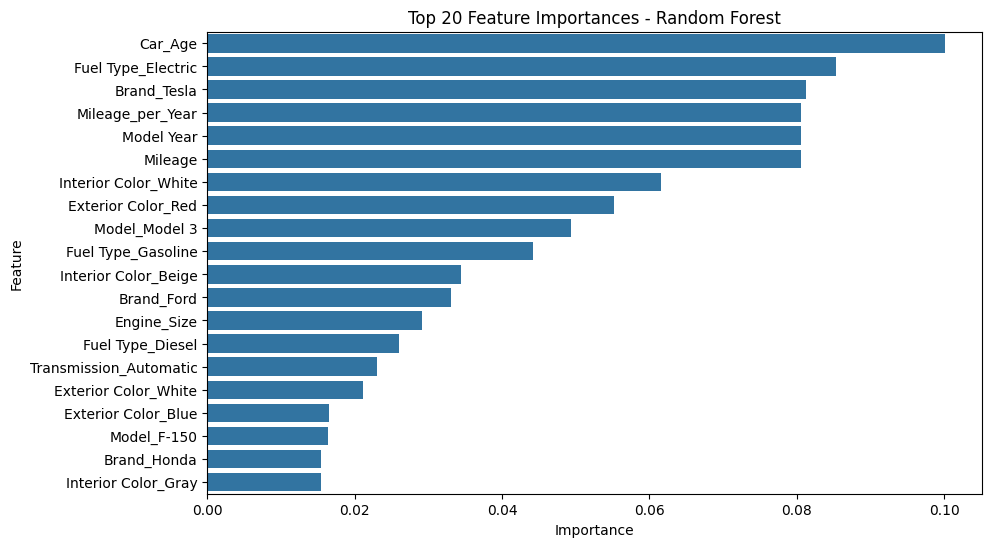

In [15]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values[:20], y=feature_importances.index[:20])
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [16]:
# Show top features
print("Top 10 important features:")
print(feature_importances.head(10))

Top 10 important features:
Car_Age                 0.100123
Fuel Type_Electric      0.085261
Brand_Tesla             0.081196
Mileage_per_Year        0.080541
Model Year              0.080526
Mileage                 0.080516
Interior Color_White    0.061575
Exterior Color_Red      0.055128
Model_Model 3           0.049323
Fuel Type_Gasoline      0.044249
dtype: float64
